<a href="https://colab.research.google.com/github/Bepo2002/Humbug-4YP/blob/main/Test_bench.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mosquito Virtual Test Bench V1.1

In [47]:
import zipfile
from scipy.io import wavfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa
from scipy.stats.mstats import winsorize

## Helper Functions

In [48]:
# Finds specific sound in zip and extracts it
def extract_sound(filename):
  zip_files = ['./drive/MyDrive/4YP/train.zip','./drive/MyDrive/4YP/dev.zip']
  folders = ['train/', 'dev/a/', 'dev/b/']
  dest_dir = './drive/MyDrive/4YP/Data'
  filename_to_extract = str(filename) + '.wav'

  for zip_path in zip_files:
    for folder in folders:
      with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        filename_to_extract = folder + filename_to_extract
        if filename_to_extract in zip_ref.namelist():
          zip_ref.extract(filename_to_extract, dest_dir)
          print(f"{filename_to_extract} has been extracted to {dest_dir}")
          final = './drive/MyDrive/4YP/Data/'+ filename_to_extract
          return wavfile.read(final)
  print(f"{filename_to_extract} not found in any of the provided ZIP files.")

# Read in .csv
def csv_read():
  metadata = pd.read_csv('./drive/MyDrive/4YP/Data/humbugdb_meta.csv')
  metadata = metadata.set_index('id')
  return metadata

def gaussian(x, mu, sigma):
  return np.exp(-((x - mu)**2) / (2 * sigma**2))

## Mosquito Mixer (see Audio_mix_test)

In [49]:
# Full function for generating noise + mosquito
def long_sound_gen(mos_num,noise_factor=1):
  metadata = csv_read()

  # Choose a long noise sound
  subset = metadata[metadata['sound_type'] == 'background']
  subset = subset.loc[metadata['length'] > 30]
  subset = subset.loc[metadata['sample_rate'] == 44100]
  sel_noise = subset.sample()
  noise_id = sel_noise.index.values[0]

  # Extract the sound wave and find samplerate
  n_samplerate, noise = extract_sound(noise_id)

  # Choose a shorter mosquito sound
  subset = metadata[metadata['sound_type'] == 'mosquito']
  subset = subset.loc[(metadata['length'] < 10) & (metadata['length'] > 3)]
  subset = subset.loc[metadata['sample_rate'] == 44100]
  sel_mos = subset.sample()
  mos_id = sel_mos.index.values[0]

  # Import the sound wave and find samplerate
  samplerate, data = extract_sound(mos_id)


  # Add sound to random time in noise
  # Initilise vectors to store new audio and whether each sample is from mosquito or noise
  new_audio = np.zeros(noise.size)
  sound_cat = np.zeros(noise.size)
  old_audio = np.zeros(noise.size)

  for i in range(0,mos_num):

    # Choose a 'time' to put the middle of mosquito sound wave
    mosquito_time = np.random.randint(data.size//2, high=noise.size-data.size//2, dtype=int)
    print("Adding mosquito noise at " + str(round(mosquito_time/samplerate,3)) + "s")

    # Put wave into long array
    new_audio[mosquito_time - data.size//2:(mosquito_time - data.size//2)+data.size] = data
    sound_cat[mosquito_time - data.size//2:mosquito_time + data.size//2] = 1

    # Generate gaussian in same place as mos audio
    x = np.linspace(0,noise.size,noise.size,dtype=int)
    y = gaussian(x,mosquito_time,data.size/6)

    # Multiply to apply gaussian to audio
    old_audio = y*new_audio + old_audio

  # Add faded mosquito sound to background noise
  full_audio = noise*noise_factor + old_audio

  return full_audio, samplerate, sound_cat

## Audio chopper

In [50]:
# Function for chopping up audio and forming matrix (each row is a clip, each column a sample)
def chop_chop(audio,samplerate,seconds_per_clip=1):
  # Choose bin size (default 1 second clip)
  bin_size = int(samplerate*seconds_per_clip)

  # Reshape Data
  rows = int(audio.size/bin_size)
  audio = audio[:rows*bin_size]
  audio = np.reshape(audio,(rows,bin_size))
  audio = np.concatenate((audio,np.zeros((rows,1))),axis=1)
  return audio

## Binarizer

In [51]:
def binarize(full_audio, av_sound_cat):
  indexs_to_remove = []
  for i in range(len(av_sound_cat)):
    if av_sound_cat[i] > 0.8:
      av_sound_cat[i] = 1
    elif av_sound_cat[i] < 0.2:
      av_sound_cat[i] = 0
    else:
      indexs_to_remove.append(i)
  av_sound_cat = np.delete(av_sound_cat,indexs_to_remove)
  full_audio = np.delete(full_audio,indexs_to_remove,axis=0)


  return full_audio, av_sound_cat


## MFCC Generation

In [52]:
# Function to generate MFCCs for one long mixed audio
def generate_training_data(mosquitoness=2, noise_factor=0.5, chop_size=1, n_mfcc=10):
  # Create the long mixed audio (mosquito + noise)
  full_audio, samplerate, sound_cat = long_sound_gen(mosquitoness,noise_factor)

  audio_normal = winsorize(full_audio)

  # Chop audio into X second clips
  chopped_audio = chop_chop(audio_normal,samplerate,chop_size)

  # Create an average 'mosquitoness' of each clip
  chopped_cat = chop_chop(sound_cat,samplerate,chop_size)
  av_chopped_cat = np.mean(chopped_cat,axis=1)

  # Binarize
  chopped_audio, av_chopped_cat = binarize(chopped_audio, av_chopped_cat)

  # Generate MFCCs for each 1s clip (squeeze as librosa function generates in 2D for some reason)
  mfccs = np.zeros((len(chopped_audio),n_mfcc))
  for i in range(0,len(chopped_audio)):
    test_var = np.squeeze(librosa.feature.mfcc(y=chopped_audio[i].astype(float), sr=samplerate, n_mfcc = n_mfcc, hop_length = len(chopped_audio[i])*2))
    mfccs[i] = test_var



  # Returns a number of seconds in audio x n_mfcc matrix and an array of sound category (how much mosquito) in each X second chop
  return mfccs, av_chopped_cat

In [53]:
# Generates training data for several long audio segments
def multiple_training_data(amount_of_audio, mosquitoness=2, noise_factor=0.5, chop_size=1, n_mfcc=10):
  X, Y = generate_training_data(mosquitoness, noise_factor, chop_size, n_mfcc)
  for i in range(0,amount_of_audio-1):
    mfccs, av_chopped_cat = generate_training_data()
    X = np.concatenate((X,mfccs))
    Y = np.concatenate((Y,av_chopped_cat))
  return X,Y

def multiple_training_random_noise(amount_of_audio, mosquitoness=2, chop_size=1, n_mfcc=10):
  X, Y = generate_training_data(mosquitoness, noise_factor=np.random.uniform(low=0.1, high=1.0))
  for i in range(0,amount_of_audio-1):
    mfccs, av_chopped_cat = generate_training_data(mosquitoness, noise_factor=np.random.uniform(low=0.1, high=1.0))
    X = np.concatenate((X,mfccs))
    Y = np.concatenate((Y,av_chopped_cat))
  return X,Y

np.random.seed(0)
coef, cats = multiple_training_random_noise(10,mosquitoness=2)

print("MFCC Matrix shape:" + str(coef.shape))
print("Mosquitoness Matrix shape:" + str(cats.shape))

train/219994.wav has been extracted to ./drive/MyDrive/4YP/Data
train/2924.wav has been extracted to ./drive/MyDrive/4YP/Data
Adding mosquito noise at 34.073s
Adding mosquito noise at 39.605s
train/220038.wav has been extracted to ./drive/MyDrive/4YP/Data
train/2628.wav has been extracted to ./drive/MyDrive/4YP/Data
Adding mosquito noise at 48.526s
Adding mosquito noise at 53.792s
train/201672.wav has been extracted to ./drive/MyDrive/4YP/Data
train/220281.wav has been extracted to ./drive/MyDrive/4YP/Data
Adding mosquito noise at 5.748s
Adding mosquito noise at 16.981s
train/220007.wav has been extracted to ./drive/MyDrive/4YP/Data
train/223222.wav has been extracted to ./drive/MyDrive/4YP/Data
Adding mosquito noise at 24.43s
Adding mosquito noise at 9.215s
train/220037.wav has been extracted to ./drive/MyDrive/4YP/Data
train/221032.wav has been extracted to ./drive/MyDrive/4YP/Data
Adding mosquito noise at 78.915s
Adding mosquito noise at 29.552s
train/220032.wav has been extracted t

## Split into training and dev

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_dev, y_train, y_dev = train_test_split(coef, cats, test_size=0.2, random_state=42)

num_mos = np.count_nonzero(cats)
num_back = len(cats) - num_mos

print("Mosquito: " + str(num_mos))
print("Not Mosquito: "  + str(num_back))

print("Samples in training set: " + str(len(X_train)))
print("Samples in dev set: " + str(len(X_dev)))

Mosquito: 101
Not Mosquito: 437
Samples in training set: 430
Samples in dev set: 108


## Test out K-nearest neighbor

[]

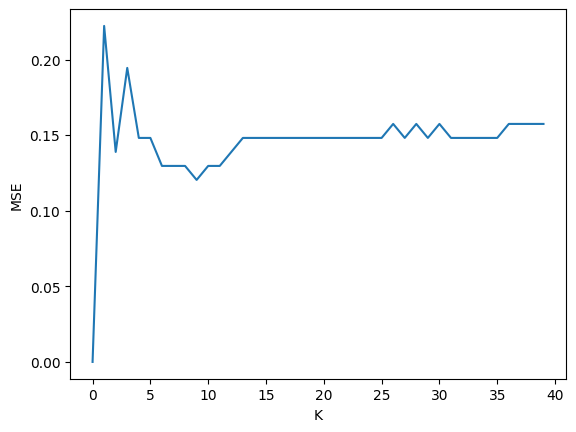

In [55]:
from sklearn.neighbors import KNeighborsClassifier

n = 40
error = np.zeros(n)

for i in range(1,n):
  neigh = KNeighborsClassifier(n_neighbors=i)
  neigh.fit(X_train, y_train)

  y_pred = neigh.predict(X_dev)

  error[i] = ((y_pred - y_dev)**2).mean()


plt.plot(error)
plt.xlabel("K")
plt.ylabel("MSE")
plt.plot()

In [56]:
print(np.argmin(error[1:]))
print(np.min(error[1:]))

8
0.12037037037037036


In [57]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

y_pred = neigh.predict(X_dev)

confusion = np.zeros((2,2))

for i in range(len(y_pred)):
  real = y_dev[i]
  pred = y_pred[i]
  confusion[int(real)][int(pred)] += 1

true_pos = confusion[1][1]
true_neg = confusion[0][0]
false_pos = confusion[0][1]
false_neg = confusion[1][0]

print("True positive: " + str(true_pos))
print("True negative: " + str(true_neg))
print("False positive: " + str(false_pos))
print("False negative: " + str(false_neg))

sensitivity = true_pos/(true_pos+false_neg)
specificity = true_neg/(true_neg+false_pos)

print("Sensitivity: " + str(sensitivity))
print("Specificity: " + str(specificity))

True positive: 7.0
True negative: 80.0
False positive: 10.0
False negative: 11.0
Sensitivity: 0.3888888888888889
Specificity: 0.8888888888888888
